In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
sns.set()

### LOAD DATASET

In [2]:
raw_data=pd.read_csv('retailed_data.csv')
dataset=raw_data.copy()
dataset.head()

,order_id,customer_id,date,order_price,delivery_charges,coupon_discount,order_total,is_expedited_delivery,latest_customer_review,is_happy_customer,customer_lat,customer_long
0,ORD182494,ID6197211592,22-06-2019,12200,79.89,10,11059.89,True,perfect phone and trusted seller. phone itself...,True,-37.815105,144.932843
1,ORD395518,ID0282825849,29-12-2019,9080,62.71,0,9142.71,False,it keeps dropping calls the wifi don't work th...,False,-37.802736,144.951118
2,ORD494479,ID6197211592,02-03-2019,10670,65.87,10,9668.87,False,five stars this is a great cheap phone.,True,-37.821302,144.957581
3,ORD019224,ID4544561904,12-01-2019,24800,57.61,15,21137.61,False,charger did not fit the charger didn't fit.,False,-37.811416,144.973073
4,ORD104032,ID6231506320,28-11-2019,9145,75.54,25,6934.29,False,four stars good,True,37.823859,144.969892


### Check if the dataset contains any NULL value

In [3]:
dataset.isnull().sum()

order_id                  0
customer_id               0
date                      0
order_price               0
delivery_charges          0
coupon_discount           0
order_total               0
is_expedited_delivery     0
latest_customer_review    0
is_happy_customer         0
customer_lat              0
customer_long             0
dtype: int64

In [4]:
#Changing the date type to be recognisable
dataset['date']=pd.to_datetime(dataset['date'],format="%d-%m-%Y")
today=dt.datetime(2020,1,1)

In [5]:
#calucaling the recency frequecy and monetary for each customer by their customer_id
rfm_data=dataset.groupby('customer_id').agg({'order_total':lambda x: x.sum(),
                                           'date':lambda x: (today-x.max()).days,
                                            'order_id':lambda x: len(x)})
rfm_data.head()

,order_total,date,order_id
customer_id,,,
ID0030385486,15585.36,108,1
ID0030385740,14145.50,182,1
ID0030946633,13195.69,181,2
ID0036822341,3912.99,253,1
ID0036825302,2152.60,59,1


In [6]:
#renaming the columns of the table
rename=['monetary', 'recency', 'frequency']
rfm_data.columns=rename
rfm_data.head()

,monetary,recency,frequency
customer_id,,,
ID0030385486,15585.36,108,1
ID0030385740,14145.50,182,1
ID0030946633,13195.69,181,2
ID0036822341,3912.99,253,1
ID0036825302,2152.60,59,1


### Plot the distribution of the predictors

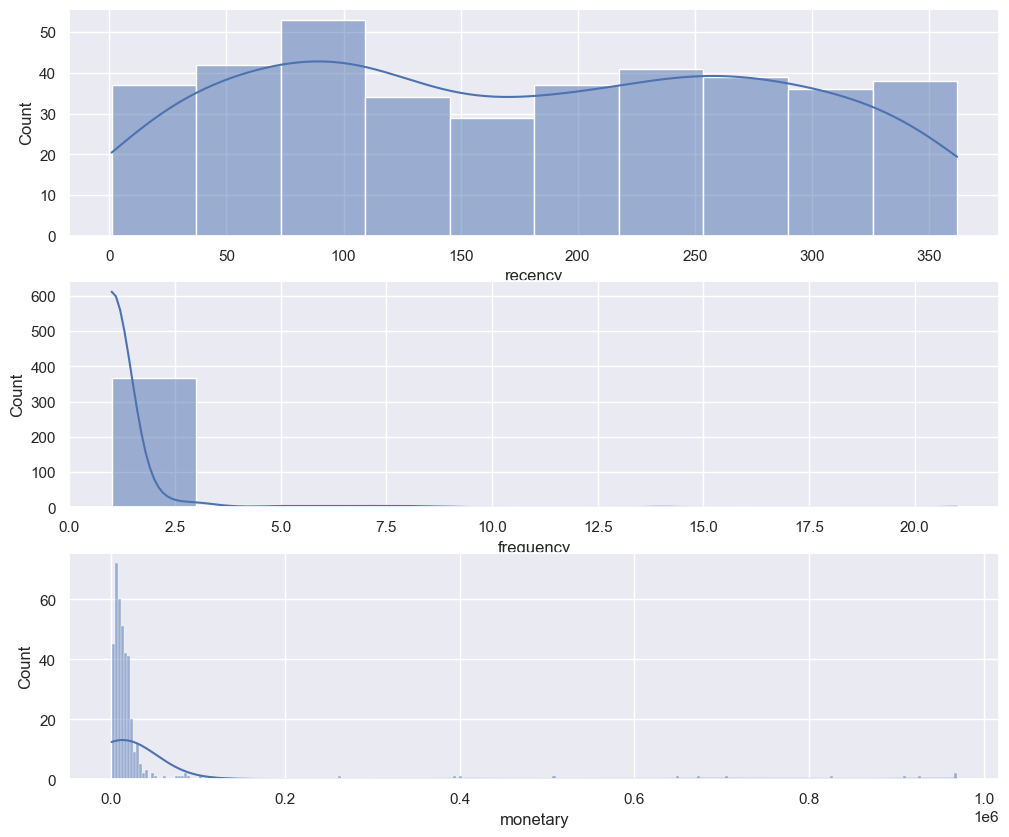

In [7]:
plt.figure(figsize=(12,10))
# Plot distribution of recency
plt.subplot(3, 1, 1); sns.histplot(data=rfm_data['recency'],kde=True)
# Plot distribution of frequency
plt.subplot(3, 1, 2); sns.histplot(data=rfm_data['frequency'],kde=True)
# Plot distribution of monetary
plt.subplot(3, 1, 3); sns.histplot(data=rfm_data['monetary'],kde=True)
# Show the plot
plt.show()

### As the predictors are not scaled then the cluster can unevenly effeted. So, scale the predictors data

In [8]:
#StandardScaler makes mean = 0 and scales the data to unit variance
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(rfm_data)
scaled_rfm=pd.DataFrame(scaled_data,columns=['monetary','recency','frequency'])
scaled_rfm.head()
#print(rfm_data['monetary'].max())

,monetary,recency,frequency
0,-0.165452,-0.662214,-0.193379
1,-0.177077,0.035491,-0.193379
2,-0.184746,0.026063,0.461396
3,-0.259695,0.704911,-0.193379
4,-0.273908,-1.124208,-0.193379


### ELBOW METHOD:

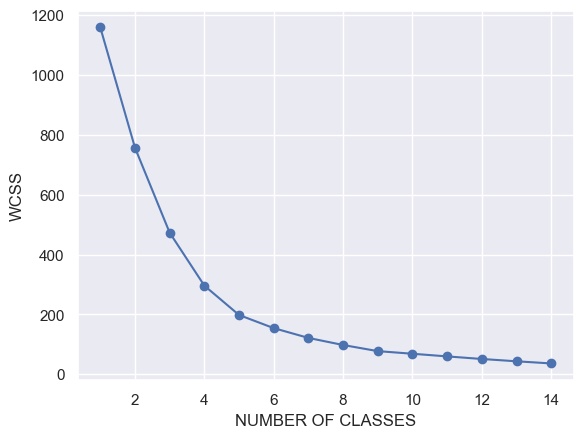

In [9]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,15):
    kmeans=KMeans(i)
    kmeans.fit(scaled_rfm)
    wcss.append(kmeans.inertia_)
clus_no=range(1,15)
plt.scatter(clus_no,wcss)
plt.plot(clus_no,wcss)
plt.xlabel('NUMBER OF CLASSES')
plt.ylabel('WCSS')
plt.show()

In [10]:
#By the plot ,the most effective k is equals to 5
kmeans=KMeans(5)
kmeans.fit(scaled_data)
rfm_data['Clusters']=kmeans.fit_predict(scaled_rfm)
rfm_data.head()

,monetary,recency,frequency,Clusters
customer_id,,,,
ID0030385486,15585.36,108,1,1
ID0030385740,14145.50,182,1,0
ID0030946633,13195.69,181,2,0
ID0036822341,3912.99,253,1,0
ID0036825302,2152.60,59,1,1


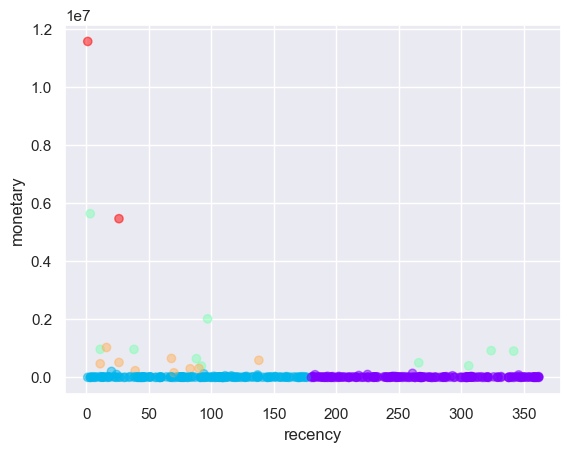

In [11]:
plt.scatter(rfm_data['recency'],rfm_data['monetary']*rfm_data['frequency'],c=rfm_data['Clusters'],cmap='rainbow',alpha=0.5)
plt.xlabel('recency')
plt.ylabel('monetary')
plt.show()

In [12]:
#Determining the cluster indicating the type of customer
rfm_data.groupby('Clusters').mean()

,monetary,recency,frequency
Clusters,,,
0,13877.161579,269.805263,1.068421
1,14080.242057,88.005714,1.062857
2,710343.300000,156.700000,1.900000
3,70442.748889,60.111111,6.333333
4,543841.720000,13.500000,17.500000


In [13]:
# Identifying that customer to different types by their cluster means
rfm_data['type']=rfm_data['Clusters'].map({0:'Need Attention',1:'promising customer',2:'Potential Customer',3:'Loyal Customer',4:'Champions'})
rfm_data.head()

,monetary,recency,frequency,Clusters,type
customer_id,,,,,
ID0030385486,15585.36,108,1,1,promising customer
ID0030385740,14145.50,182,1,0,Need Attention
ID0030946633,13195.69,181,2,0,Need Attention
ID0036822341,3912.99,253,1,0,Need Attention
ID0036825302,2152.60,59,1,1,promising customer


### Identifying the customers who need attention

In [21]:
attention=rfm_data.loc[rfm_data.Clusters==0].copy()
attention.head()

,monetary,recency,frequency,Clusters,type
customer_id,,,,,
ID0030385740,14145.50,182,1,0,Need Attention
ID0030946633,13195.69,181,2,0,Need Attention
ID0036822341,3912.99,253,1,0,Need Attention
ID0054552169,47601.97,261,3,0,Need Attention
ID0076459536,7900.74,250,1,0,Need Attention


In [50]:
targeted_customers=attention.index.values
print(targeted_customers.shape)

(190,)


### Displaying the locations areas to target

In [77]:
from folium.plugins import HeatMap
lats=dataset.loc[dataset.customer_id.isin(targeted_customers),'customer_lat']
longs=dataset.loc[dataset.customer_id.isin(targeted_customers),'customer_long']
Data=np.transpose(np.vstack((lats,longs)))
m1= folium.Map(location=[-37.8136,144.9631], tiles='cartodbpositron', zoom_start=13)
HeatMap(data=Data,radius=13).add_to(m1)
m1